# Credit Card Fraud Detection

The goal of this notebook is to analize the dataset and detect fraudulent transactions.

- The dataset contains transactions made by credit cards in September 2013 by european cardholders.
- This dataset presents transactions that occurred in two days.
- Features from V1 to V28 are the result of PCA transformation.
- Time contains the seconds elapsed between each transaction and the first transaction in the dataset.
- Amount is the transaction amount.
- Class is the target variable, it takes a value of 1 in case of fraud and 0 otherwise.

In [39]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix

# read csv
df = pd.read_csv('creditcard.csv')

In [2]:
# shows percentages of each class value in the dataset
n_classes = df['Class'].value_counts()
total = df['Class'].count()
print(f'There are {total} values, from which {n_classes[0]} are not fraud and {n_classes[1]} are fraud.\n')
print(f'No fraud: {round(n_classes[0]*100/total,1)} %\nFraud:    {round(n_classes[1]*100/total,1)} %')

There are 284807 values, from which 284315 are not fraud and 492 are fraud.

No fraud: 99.8 %
Fraud:    0.2 %


Most of the observations in the dataset are from non-fraudulent cases, as a result the dataset is imbalanced.

### Balancing the data

We can apply different techniques in order to balance our data, but the easiest one is to take a sample from the predominant class (not fraud) with the same size as the minor class (fraud).

In [3]:
# selects the fraudulent observations
fraud = df.loc[df['Class']==1]

# takes a random sample from the non fraudulent observations, equal to the size of the fraudulent observations
no_fraud = df.loc[df['Class']==0].sample(n=fraud.shape[0], random_state=0)

df_balanced = fraud.append(no_fraud)
print('Now we have a new dataframe with the same number of fraudulent and non fraudulent observations.\n')

# shuffle the new dataframe
df_balanced = df_balanced.sample(frac=1, random_state=0)
df_balanced.reset_index(drop=True, inplace=True)

print(df_balanced['Class'].value_counts())

Now we have a new dataframe with the same number of fraudulent and non fraudulent observations.

1    492
0    492
Name: Class, dtype: int64


### Standarize dataframe

First, the dataframe is separated in a feature matrix __X__ and target vector __y__.

In [4]:
X = df_balanced.drop(columns='Class')
y = df_balanced['Class']

In [5]:
# save feature column names
feature_cols = X.columns

# standarize feature matrix
scaler = preprocessing.StandardScaler()
X_std = scaler.fit_transform(X)

# goes back from np array to dataframe
X_std = pd.DataFrame(X_std, columns=feature_cols)

### Visualize correlations

Text(0.5, 1, 'Correlations')

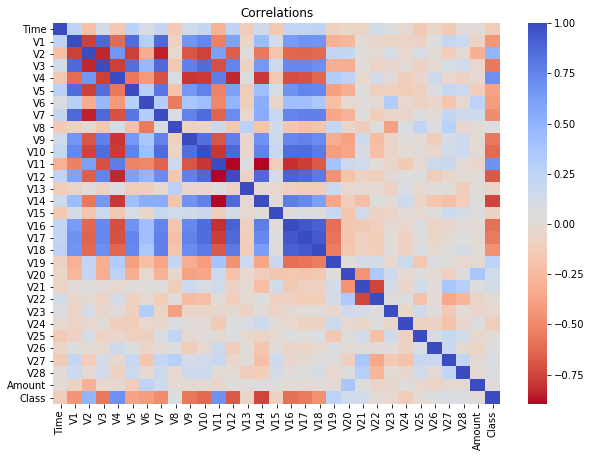

In [6]:
# visualize correlations
corr = X_std.join(y).corr()
fig, hm = plt.subplots(figsize=(10,7))    
hm = sns.heatmap(corr, cmap='coolwarm_r')
hm.set_title('Correlations')

From this plot it is possible to see two main things:

- Features from V1 to V18 are more or less correlated, this is not a good thing because it means there are redundant features.
- Features from V1 to V18 present a relatively strong correlation with the target, this is a good thing since they will help us predict a target value.

I will focus the analysis in the next features: Time, V1, V2, V3, V4, V5, V6, V7, V9, V10, V11, V12, V14, V16, V17, V18 and I will refer to them as "used_columns" from now on.

In [7]:
used_columns = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18']

# drops columns in both standarized and not standarized feature matrixes
X = X[used_columns]
X_std = X_std[used_columns]

### K-Nearest Neighbors Model

We will use KNN classifier and GridSearchCv to find the best value of K.

In [8]:
# Create a KNN classifier
knn = KNeighborsClassifier(n_jobs=-1)

# Create standardizer
scaler = preprocessing.StandardScaler()

# Create a pipeline
pipeline = Pipeline([("scaler", scaler), ("knn", knn)])

# Create space of candidate values
search_space = [{"knn__n_neighbors": [1, 2, 3, 4, 5, 6, 7]}]


# Create grid search
classifier = GridSearchCV(pipeline, search_space, cv=5, verbose=0)

# Fit grid search
model_knn = classifier.fit(X, y)

In [9]:
# drop unused columns of original dataframe, separate in X and and test model with original dataframe
df_X = df.drop(columns='Class')
df_X = df_X[used_columns]
df_y = df['Class']

y_predicted = model_knn.predict(df_X)

In [10]:
# Best neighborhood size (k)
K = model_knn.best_estimator_.get_params()["knn__n_neighbors"]
print(f'The best value of K is: {K}')

The best value of K is: 4


In [11]:
from sklearn.metrics import accuracy_score
print(f'Accuracy: {round(accuracy_score(df_y,y_predicted)*100,2)} %')

Accuracy: 98.5 %


(Text(33.0, 0.5, 'True Class'), Text(0.5, 15.0, 'Predicted Class'))

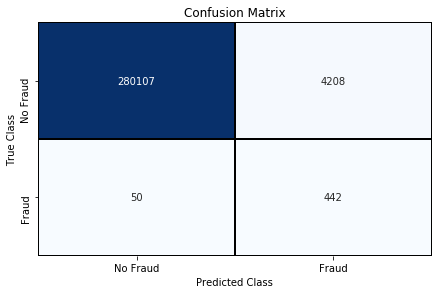

In [12]:
from sklearn.metrics import confusion_matrix

# Create confusion matrix
matrix = confusion_matrix(df_y, y_predicted)

# represents confusion matrix with heatmap
dataframe = pd.DataFrame(matrix, index=['No Fraud', 'Fraud'], columns=['No Fraud', 'Fraud'])
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt='g', linewidths=1, linecolor='black')
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")

- 280107 true negatives
- 442 true positives
- 50 false negatives: predicted no fraud, actually fraud
- 4208 false positives: predicted fraud, actually no fraud

### SMOTE

In [13]:
# supress annoying warning message
import warnings
warnings.filterwarnings("ignore")

# select the used columns from the features dataframe
df_X = df_X[used_columns]

sm = SMOTE(random_state=1)
X_res, y_res = sm.fit_resample(df_X,df_y)

X_res = pd.DataFrame(X_res, columns=df_X.columns)
y_res = pd.DataFrame(y_res, columns=['Class'])
print(y_res['Class'].value_counts())

1    284315
0    284315
Name: Class, dtype: int64


Now the data is balanced, but in this case we created new observations in order to balance the data.

In [14]:
# create a KNN classifier
knn = KNeighborsClassifier(n_neighbors=4, n_jobs=-1)

# create standardizer
scaler = preprocessing.StandardScaler()

# create a pipeline
pipeline = Pipeline([("scaler", scaler), ("knn", knn)])

# cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)

cv_results = cross_val_score(pipeline, X_res, y_res, cv=kf, scoring="accuracy", n_jobs=-1)

In [15]:
# Calculate mean
print(f'Accuracy: {round(cv_results.mean()*100,2)} %')

Accuracy: 99.95 %


In [16]:
model_smote = pipeline.fit(X_res,y_res)

In [17]:
y_predicted = model_smote.predict(df_X)

(Text(33.0, 0.5, 'True Class'), Text(0.5, 15.0, 'Predicted Class'))

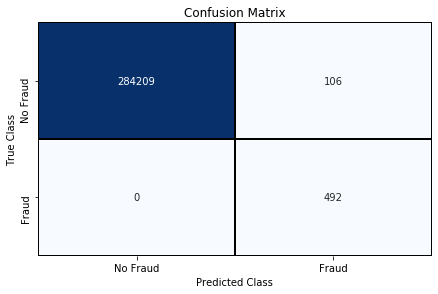

In [18]:
# create confusion matrix
matrix = confusion_matrix(df_y, y_predicted)

# represents confusion matrix with heatmap
dataframe = pd.DataFrame(matrix, index=['No Fraud', 'Fraud'], columns=['No Fraud', 'Fraud'])
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt='g', linewidths=1, linecolor='black')
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")

- 284209 true negatives
- 492 true positives
- 0 false negatives: predicted no fraud, actually fraud
- 106 false positives: predicted fraud, actually no fraud

We can see that there is an improvement compared to the previous under-sampling method.

### Neural Networks

We will use the over-sampled data to train a Neural Network model and then see if there is any improvement.

In [34]:
import tensorflow as tf
from tensorflow import keras

# number of features
n_inputs = X_res.shape[1]

# split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,random_state=0, test_size=0.2)

# standarize
scaler = preprocessing.StandardScaler()

# transform
scaler.fit(X_train)
X_std = scaler.transform(X_train)
X_test = scaler.transform(X_test)


NNmodel = keras.Sequential([
    keras.layers.Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),  # input layer (1)
    keras.layers.Dense(30, activation='relu'),  # hidden layer (2)
    keras.layers.Dense(1, activation='sigmoid') # output layer (3)
])

NNmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = NNmodel.fit(X_std, y_train, epochs=7, validation_data=(X_test, y_test))

Train on 454904 samples, validate on 113726 samples
Epoch 1/7
454904/454904 [==============================] - 16s 36us/sample - loss: 0.0604 - acc: 0.9782 - val_loss: 0.0372 - val_acc: 0.9873
Epoch 2/7
454904/454904 [==============================] - 16s 36us/sample - loss: 0.0326 - acc: 0.9887 - val_loss: 0.0410 - val_acc: 0.9870
Epoch 3/7
454904/454904 [==============================] - 16s 35us/sample - loss: 0.0271 - acc: 0.9908 - val_loss: 0.0239 - val_acc: 0.9924
Epoch 4/7
454904/454904 [==============================] - 17s 37us/sample - loss: 0.0237 - acc: 0.9921 - val_loss: 0.0227 - val_acc: 0.9922
Epoch 5/7
454904/454904 [==============================] - 17s 38us/sample - loss: 0.0211 - acc: 0.9930 - val_loss: 0.0250 - val_acc: 0.9909
Epoch 6/7
454904/454904 [==============================] - 18s 40us/sample - loss: 0.0193 - acc: 0.9937 - val_loss: 0.0180 - val_acc: 0.9946
Epoch 7/7
454904/454904 [==============================] - 18s 40us/sample - loss: 0.0181 - acc: 0.994

Text(0.5, 0, 'Epoch')

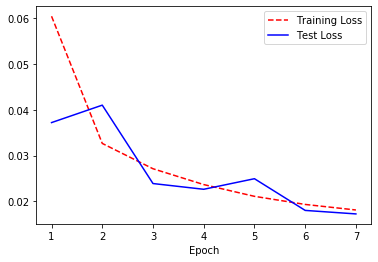

In [35]:
# get training and test loss histories
training_loss = history.history["loss"]
test_loss = history.history["val_loss"]

# create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# visualize loss history
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training Loss", "Test Loss"])
plt.xlabel("Epoch")

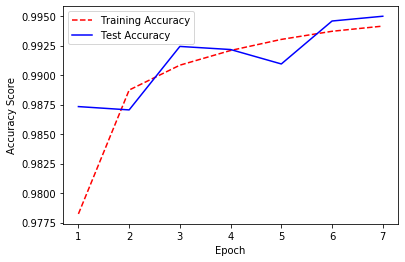

In [36]:

# get training and test accuracy histories
training_accuracy = history.history["acc"]
test_accuracy = history.history["val_acc"]
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count, test_accuracy, "b-")

# visualize accuracy history
plt.legend(["Training Accuracy", "Test Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy Score")
plt.show();

In [37]:
# make predictions
NN_pred = NNmodel.predict(scaler.transform(df_X))

(Text(33.0, 0.5, 'True Class'), Text(0.5, 15.0, 'Predicted Class'))

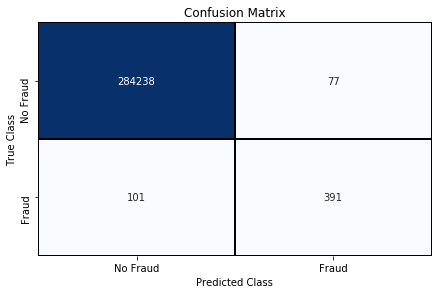

In [38]:
# create confusion matrix
matrix = confusion_matrix(df_y, NN_pred.astype(int))

# represents confusion matrix with heatmap
dataframe = pd.DataFrame(matrix, index=['No Fraud', 'Fraud'], columns=['No Fraud', 'Fraud'])
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt='g', linewidths=1, linecolor='black')
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")

### Conclusions

Almost a third part of the features present little or no correlation with the target. Some of the features that correlate with the target correlate with each other as well. This could mean that there is redundancy in the information provided by some of these features.

3 different methods for classifying the data were tried:

- KNN with under-sampled data
- KNN with over-sampled data using SMOTE
- Neural Networks

Using KNN with under-sampled data leads to bad results (4208 false positives and 50 false negatives). This is due to the fact that a lot of the observations were left out during the undersampling. The KNN under-sampled model had best results when K=4.

There was a big improvement using KNN with the over-sampling method. This led to 106 false positives and 0 false negatives. Again, the best results were achieved when using K=4.

Lastly, a feedforward neural network model was implemented. This NN was composed of 1 Dense input layer, one hidden layer with 16 neurons and 1 dense output layer with 1 neuron and a sigmoid activation function. The results were a little bit worse than the previous method.